In [1]:
import servo
import analyse
import plot

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#known_xs, known_ps, known_ps_errs = servo.ask_for_defined_points()
known_ps = [[86.38E-6, 148.8E-6], [11.45E-6, 14.95E-6], ]
known_xs = [[2200, 3800], [4900, 1800], ]

measurements = {
    "position": [10,10,10],
    "displacement": [1,2,3],
    "power": [5,6,7],
    "std_dev": [0.1,0.3,.5],
}

meas_data = pd.DataFrame(measurements).set_index("position")
meas_data


,displacement,power,std_dev
position,,,
10,1,5,0.1
10,2,6,0.3
10,3,7,0.5


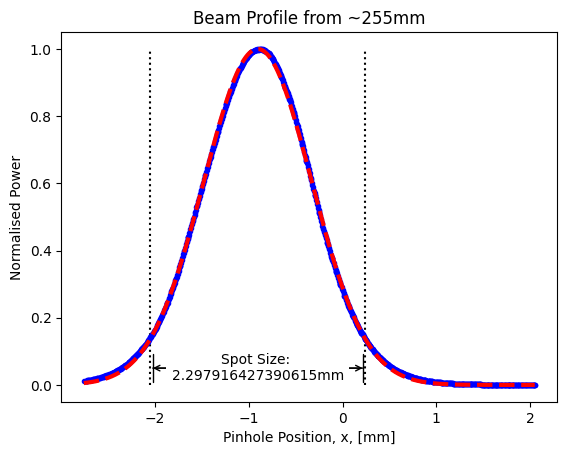

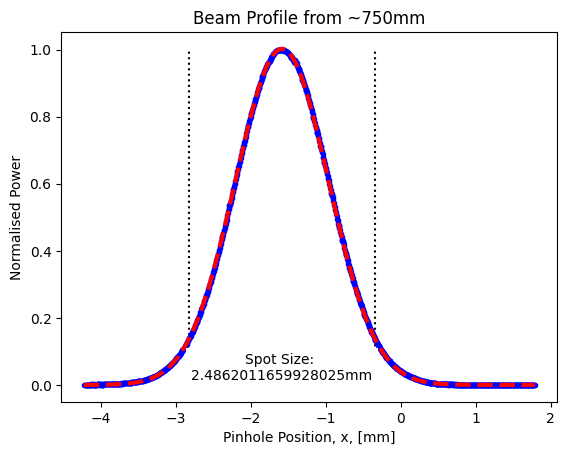

In [3]:

data = servo.get_data("Data/servo-attempt-1.csv")

well_defined_data = servo.get_rows_with_known_displacement(data, known_ps[0])
speed = servo.characterise_speed(well_defined_data, known_xs[0])
data = servo.convert_time_to_displacement(data, well_defined_data, speed)
plot.plot_beam_profile(data, "Beam Profile from ~255mm")

data = servo.get_data("Data/servo-data-2.csv")

well_defined_data = servo.get_rows_with_known_displacement(data, known_ps[1])
speed = servo.characterise_speed(well_defined_data, known_xs[1])
data = servo.convert_time_to_displacement(data, well_defined_data, speed)
plot.plot_beam_profile(data, "Beam Profile from ~750mm")
plt.show()

w0 is: [0.0011578]


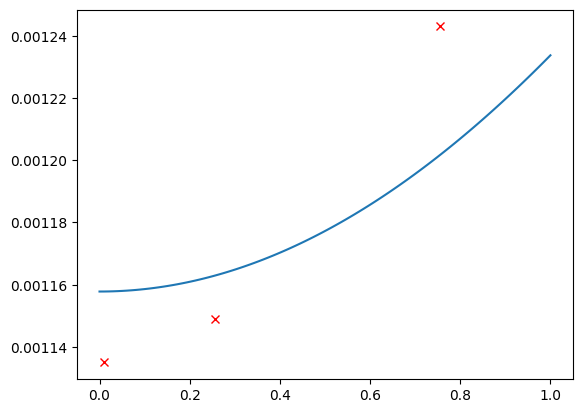

In [4]:
zs = [10.2E-3, 256.5E-3, 256E-3 + (20*25E-3)]
tws = [2.27E-3, 2.2979E-3, 2.486E-3]
ws = list(map(lambda w: w/2, tws))
plot.plot_parametric(zs, ws)